# Visualizing the saliency maps

Once your classifier is trained you can visualize which pixels where the most relevant to estimate the volume of wine (or any other liquid) in an image. This is what we call the *saliency maps*.

We will use the implementations of different saliency functions from the [deep-viz repository](https://github.com/experiencor/deep-viz-keras) by [experiencor](https://github.com/experiencor) which allows the visualization of saliency maps for keras models.

In [2]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop

# User parameters to set
TIMESTAMP = '2023-09-14_105236'                       # timestamp of the model
MODEL_NAME = 'epoch-16.hdf5'                           # model to use to make the prediction
TOP_K = 2                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
filepath = os.path.join(paths.get_checkpoints_dir(), MODEL_NAME)
obj=utils.get_custom_objects()

# Load the model
model = load_model(filepath, custom_objects=obj)

W0918 14:31:34.849447 139707316275008 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0918 14:31:34.852168 139707316275008 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0918 14:31:34.853740 139707316275008 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Now you can select a file in your computer in which to visualize the saliency maps. 
Possible visualizations include:
* [Vanila gradient](https://arxiv.org/abs/1312.6034)
* [Integrated gradients](https://arxiv.org/abs/1703.01365)

Each of them is accompanied with the corresponding [smoothgrad](https://arxiv.org/abs/1706.03825) version, which improves on any baseline method by adding random noise.

In [3]:
import json
import pandas as pd

prediccion_path='/srv/image-classification-tf/models/2023-09-14_105236/predictions/epoch-16.hdf5+test.json'
with open(prediccion_path) as f:
    prediccion_data = json.load(f)
    
prediccion_df = pd.DataFrame.from_dict(prediccion_data)
prediccion_df['abs_error'] = abs(prediccion_df.pred_value-prediccion_df.true_value)
prediccion_df = prediccion_df.sort_values(by=['abs_error'])
prediccion_df.columns=['filepath', 'pred_value', 'true_value', 'abs_error']
prediccion_df['filenames']=prediccion_df.apply(lambda row: row.filepath[0:-4].split('/')[-1], axis=1) #Separamos por barraBaja, quitando .JPG

In [4]:
best_pred = prediccion_df.head(10)
worst_pred = prediccion_df.tail(10).sort_values(by=['abs_error'], ascending=False)

In [5]:
print(best_pred)

                                               filepath  pred_value  \
1764  /storage/MANZANA/Golden/139.04/Rio_M_Golden_13...  139.079330   
722   /storage/MANZANA/Fuji/144.23/Rio_M_Fuji_144,23...  144.172836   
552   /storage/MANZANA/Golden/147.55/Rio_M_Golden_14...  147.463776   
289   /storage/MANZANA/Golden/191,83/Rio_M_Golden_19...  191.922989   
323   /storage/MANZANA/Golden/191,83/Rio_M_Golden_19...  191.725204   
1586  /storage/MANZANA/Fuji/132.58/Rio_M_Fuji_132,58...  132.702484   
94    /storage/MANZANA/Fuji/215.90/Rio_M_Fuji_215,90...  215.757950   
670   /storage/MANZANA/Golden/240.16/Rio_M_Golden_24...  240.326431   
765   /storage/MANZANA/Fuji/144.23/Rio_M_Fuji_144,23...  144.403473   
1388  /storage/MANZANA/Granny Smith/178,97/Mad_M_Gra...  178.794739   

      true_value  abs_error                                 filenames  
1764  139.039993   0.039337        Rio_M_Golden_139,04_Spb_ext_me_ver  
722   144.229996   0.057159          Rio_M_Fuji_144,23_Pgb_ext_al_ver  
55

In [5]:
def generate_saliency(FILEPATH, FILENAME, pred_value, true_value, TYPE):
    saliency_types = [GradientSaliency, IntegratedGradients]

    figsize = 5
    fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
    top_title = "Peso Original: "+str(true_value)+"\nPeso Predicho: "+str(pred_value)
    fig.suptitle(top_title, fontsize=24, y=1.05) #Titulo General TODO: Probar...
    gs = axs[0, 0].get_gridspec()
    # remove the underlying axes
    for ax in axs[0:, 0]:
        ax.remove()
    axbig = fig.add_subplot(gs[0:, 0])

    # Load the image and preprocess it for the saliency maps computation
    data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                    im_size=conf['model']['image_size'],
                                    mean_RGB=conf['dataset']['mean_RGB'],
                                    std_RGB=conf['dataset']['std_RGB'],
                                    preprocess_mode=conf['model']['preprocess_mode'],
                                    aug_params=None,
                                    crop_mode='random',
                                    crop_number=1)

    img_arr = data_gen.__getitem__(0)
    img_arr = img_arr.squeeze(axis=0)

    # Original image
    image = data_utils.load_image(FILEPATH)#
    image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])

    axbig.imshow(image)
    axbig.set_title('Original image', fontsize=32, pad=18)
    axbig.set_xticks([])
    axbig.set_yticks([])
    axbig.xaxis.set_visible(False)
    axbig.yaxis.set_visible(False)
    axs = axs.T.flatten()
    # fig.delaxes(axs[1])
    axs = axs[2:]

    # Saliency maps
    # right
    axs[2].set_ylabel('Standard', fontsize=31,rotation=270, labelpad=31)
    axs[3].set_ylabel('Smoothed', fontsize=31,rotation=270, labelpad=31)
    # left
    # axs[0].set_ylabel('Standard', fontsize=12)
    # axs[1].set_ylabel('Smoothed', fontsize=12)
    for i, f in enumerate(saliency_types):
        print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
        saliency_func = f(model)

        # Normal map
        mask = saliency_func.get_mask(img_arr)
        mask = np.sum(np.abs(mask), axis=2)
        axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
        axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=32, pad=18)

        # Smoothgrad map
        mask = saliency_func.get_smoothed_mask(img_arr)
        mask = np.sum(np.abs(mask), axis=2)
        axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.yaxis.set_label_position("right")

    fig.tight_layout(pad=1.0)
    result_path = '/srv/image-results/saliencyMaps/'+TYPE+'/'+FILENAME
    plt.savefig(result_path,bbox_inches='tight')
    # Print predicted labels
    #pred_value = predict(model, FILEPATH, conf)
    #print('Predicted value:')
    #print('{}'.format(pred_value[0]))

## Best predictions

[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients


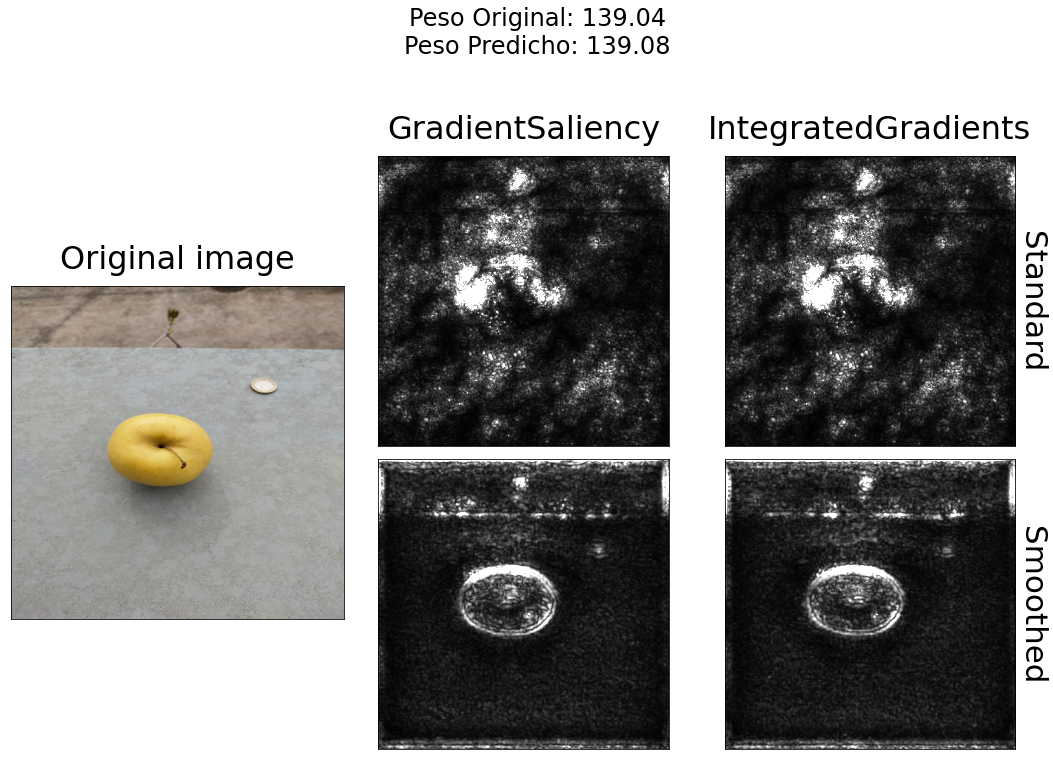

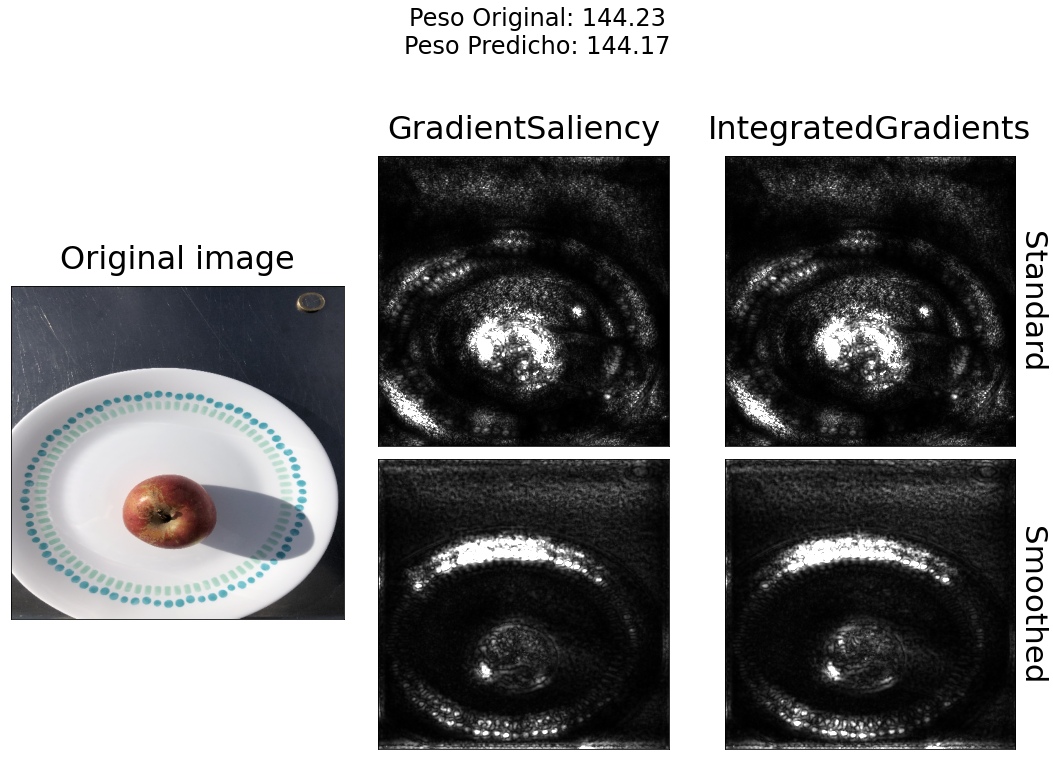

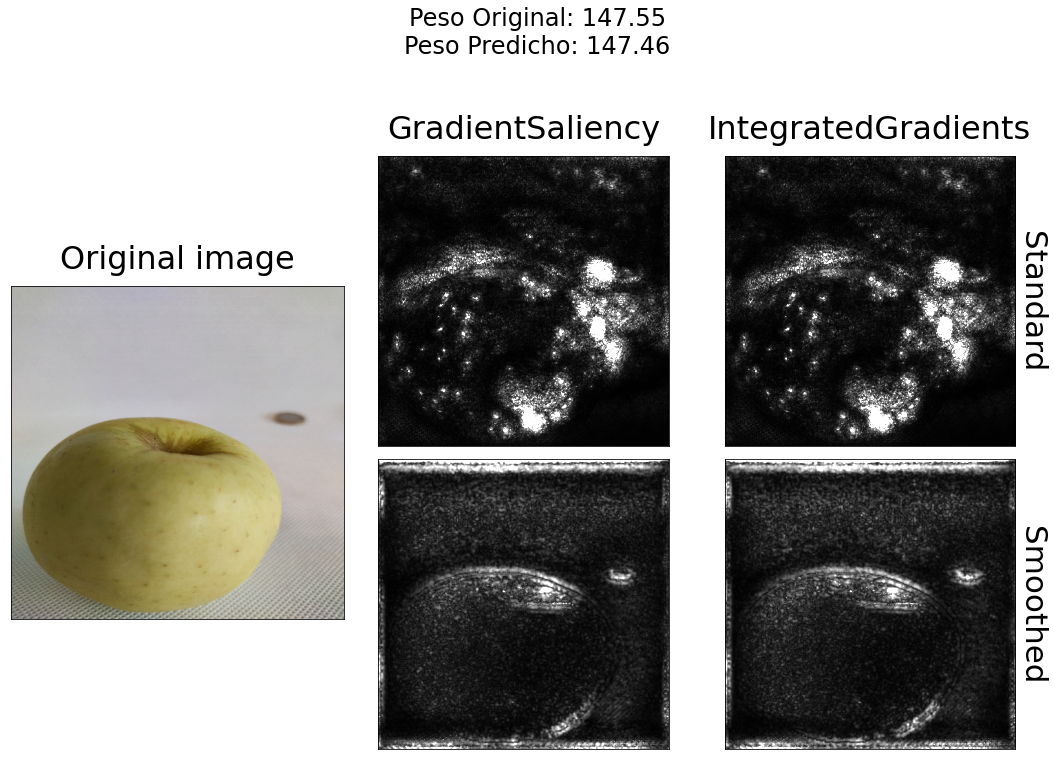

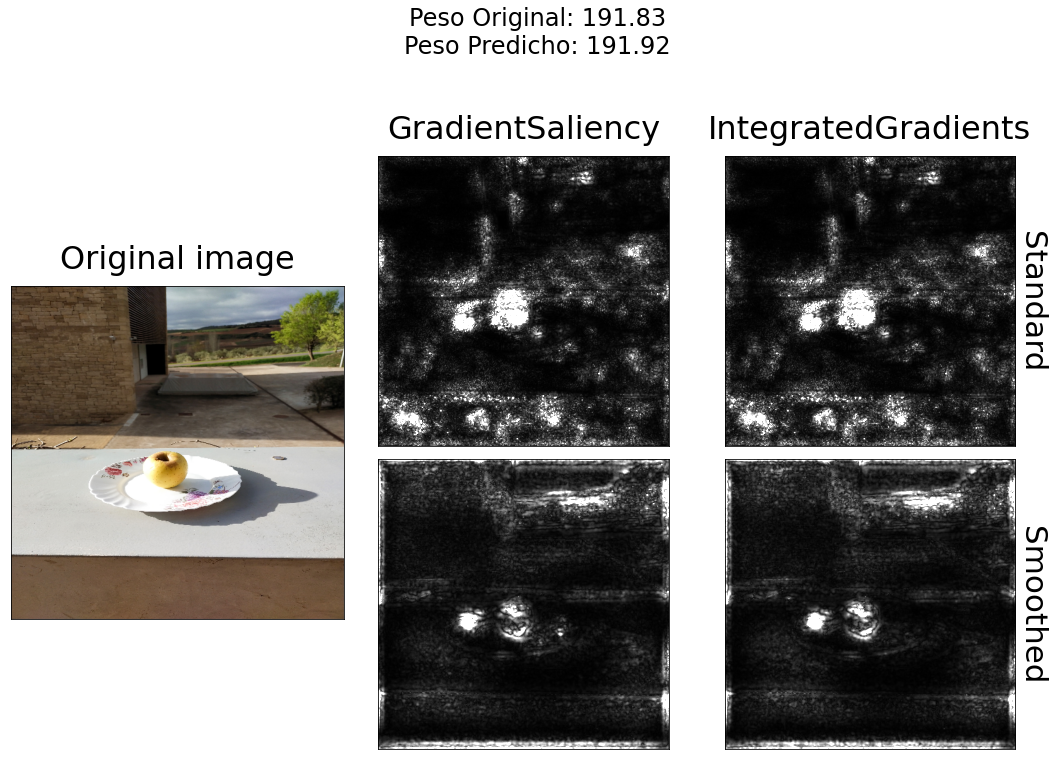

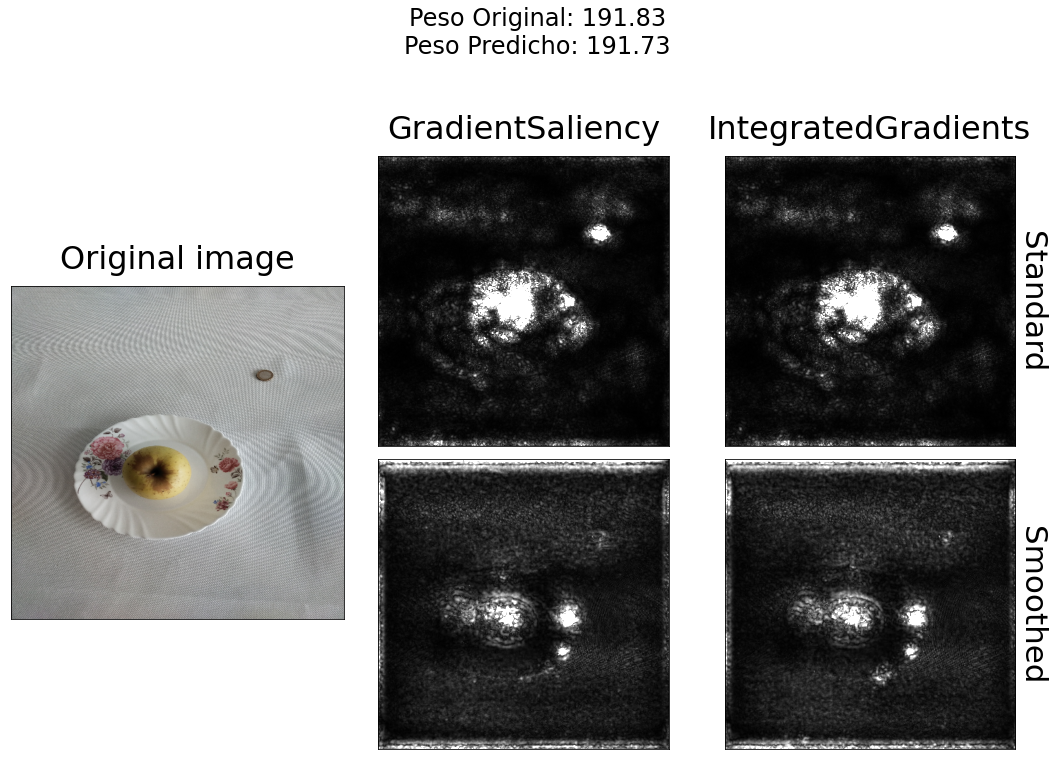

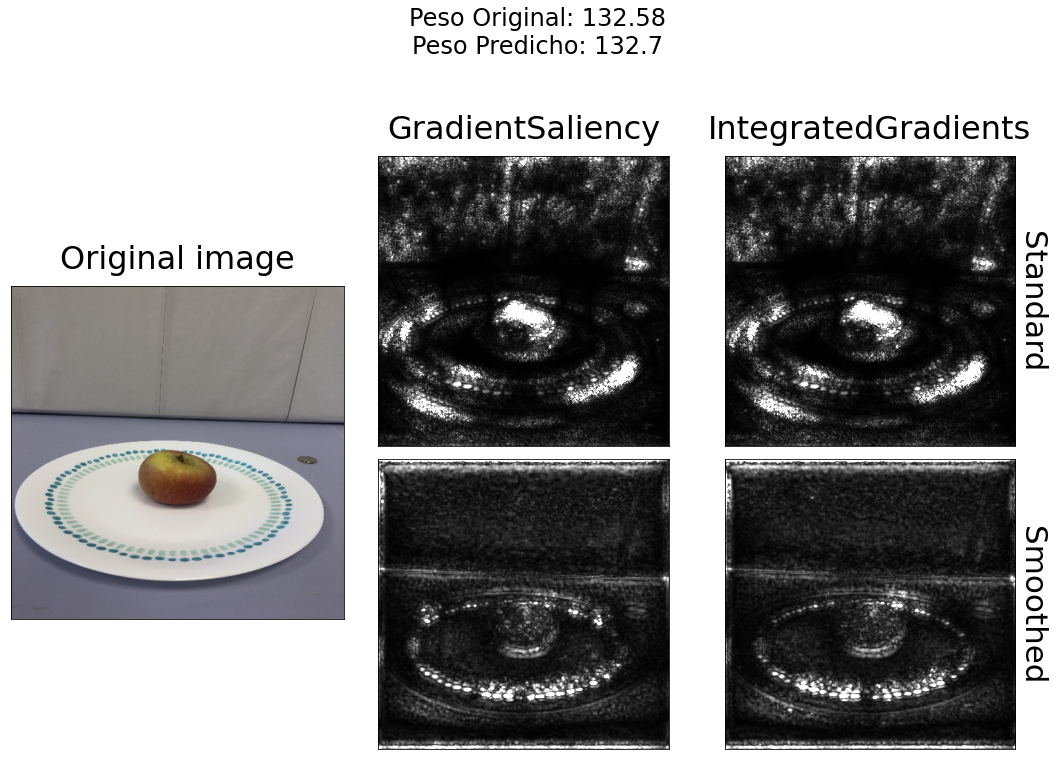

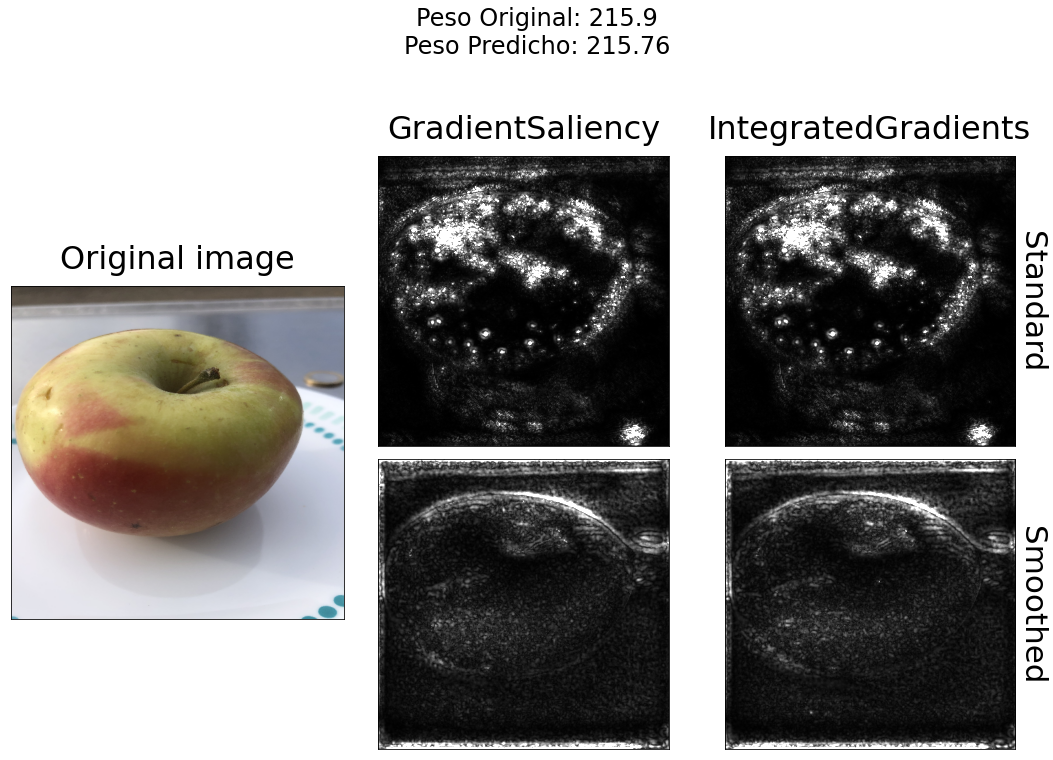

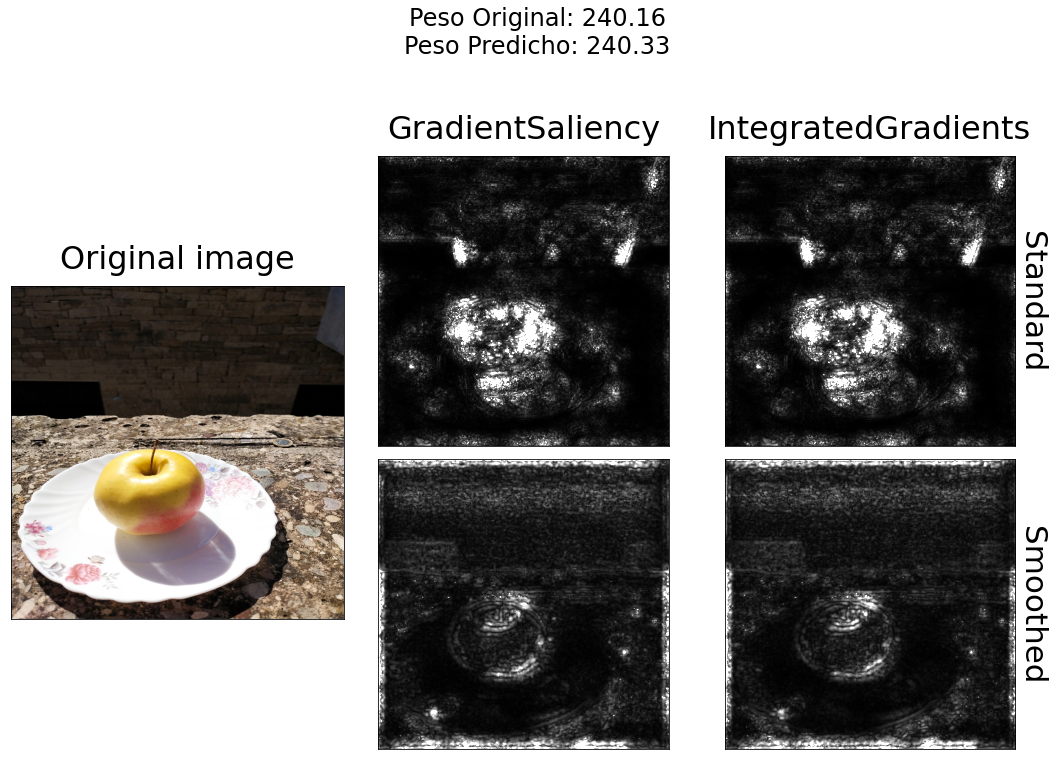

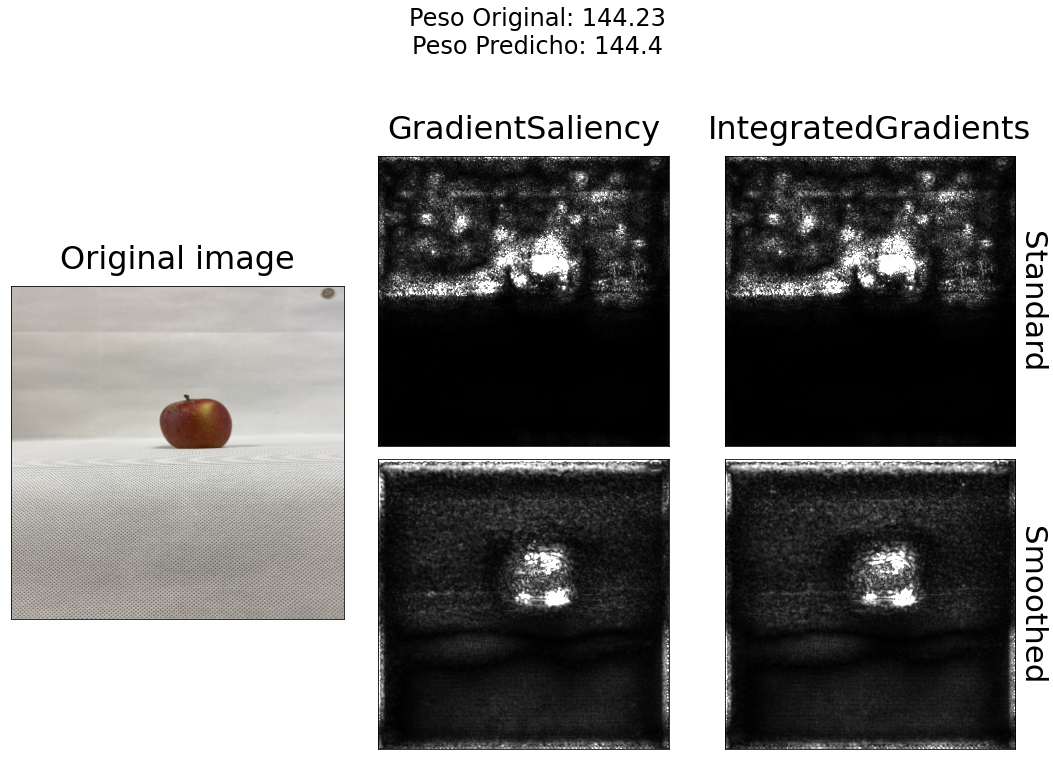

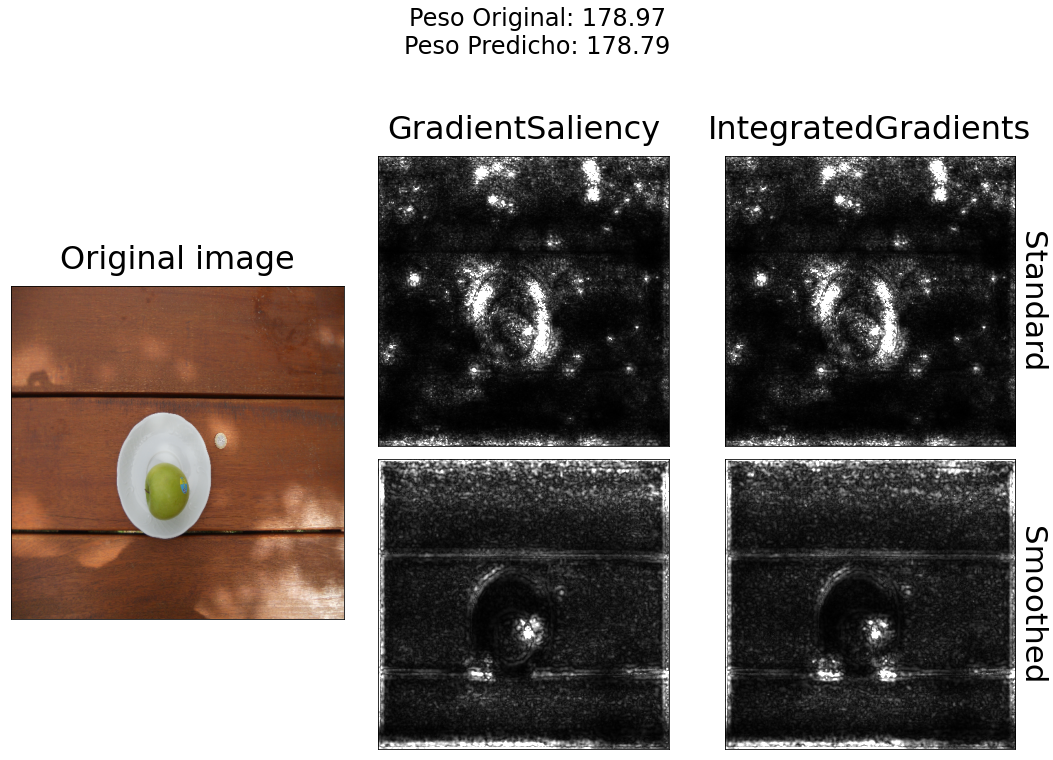

In [6]:
for filepath,filename, pred_value, true_value in zip(best_pred['filepath'],best_pred['filenames'],best_pred['pred_value'],best_pred['true_value']) :
    #print(filepath,filename, pred_value, true_value)
    # Generate_saliency
    pred_value = float("{:.2f}".format(pred_value))
    true_value = float("{:.2f}".format(true_value))
    generate_saliency(filepath, filename, pred_value, true_value, "best")

## Worst predictions

In [7]:
print(worst_pred)

                                               filepath  pred_value  \
1361  /storage/MANZANA/Fuji/296.05/Rio_M_Fuji_296,05...  168.181107   
1367  /storage/MANZANA/Fuji/296.05/Rio_M_Fuji_296,05...  170.277451   
732   /storage/MANZANA/Fuji/144.23/Rio_M_Fuji_144,23...  264.908020   
948   /storage/MANZANA/Fuji/265.43/Rio_M_Fuji_265,43...  155.676834   
1309  /storage/MANZANA/Fuji/296.05/Rio_M_Fuji_296,05...  194.677887   
1364  /storage/MANZANA/Fuji/296.05/Rio_M_Fuji_296,05...  194.784561   
786   /storage/MANZANA/Fuji/144.23/Rio_M_Fuji_144,23...  244.149353   
1343  /storage/MANZANA/Fuji/296.05/Rio_M_Fuji_296,05...  197.457809   
1310  /storage/MANZANA/Fuji/296.05/Rio_M_Fuji_296,05...  197.544571   
1358  /storage/MANZANA/Fuji/296.05/Rio_M_Fuji_296,05...  198.036636   

      true_value   abs_error                         filenames  
1361  296.049988  127.868881  Rio_M_Fuji_296,05_Spm_int_al_ver  
1367  296.049988  125.772537  Rio_M_Fuji_296,05_Spm_int_me_ver  
732   144.229996  120.6

In [ ]:
#Worst predictions
for filepath,filename, pred_value, true_value in zip(worst_pred['filepath'],worst_pred['filenames'],worst_pred['pred_value'],worst_pred['true_value']) :
    #print(filepath,filename, pred_value, true_value)
    # Generate_saliency
    generate_saliency(filepath, filename, pred_value, true_value, "worst")

[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
[1/2] GradientSaliency
[2/2] IntegratedGradients
